In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/nlp'

/content/drive/MyDrive/nlp


# Phân loại cảm xúc trong văn bản sử dụng LSTM và Word2Vec

### Architecture:
(X) Văn bản -> Embedding (sử dụng pretrained W2V) -> Deep Network (LSTM/GRU) -> Fully Connected (Dense) -> Output Softmax -> Emotion (Y)

#### Embedding Layer
* Sử dụng các vector 300 chiều được pretrained W2V.

#### Deep Network
* Deep network nhận các input là embedding vectors rồi chuyển đổi chúng thành compressed representation. The compressed representation effectively captures all the information in the sequence of words in the text. Deep Network ở đây dùng biến thế LSTM/GRU.

#### Output Layer
* Dựa vào bài toán, tầng này có thể có sigmoid cho binary classification hoặc softmax cho cả binary và multi classification.

## Workflow:
1. Import Dữ liệu
2. Chuẩn bị input data
3. Import pre-trained W2V
4. Tạo Neural Network Pipeline
5. Train model
6. Evaluate kết quả


## 1. Import Dữ liệu


In [3]:
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
import re

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

Defining vector space dimension and fixed input size

In [4]:
num_classes = 5

embed_num_dims = 300

max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [5]:
data_train = pd.read_csv('data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train._append(data_test, ignore_index=True)

In [6]:
print(data.Emotion.value_counts())
data.head(6)

Emotion
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: count, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


## 2. Prepare input data

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
def clean_text(data):

    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)

    data = word_tokenize(data)

    return data

In [9]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [10]:
print(texts_train[92])

a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .


**Tokenization + fitting bằng keras**

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12087


## Padding

Thêm padding cho các input bằng nhau (với max_len là 250 từ)

In [12]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10258,   173,    13]], dtype=int32)

In [13]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## 2. Import pretrained word vectors

Import pretrained word2vec từ file nằm ở wikipedia (Bài báo về fasttext) và tạo embedding matrix
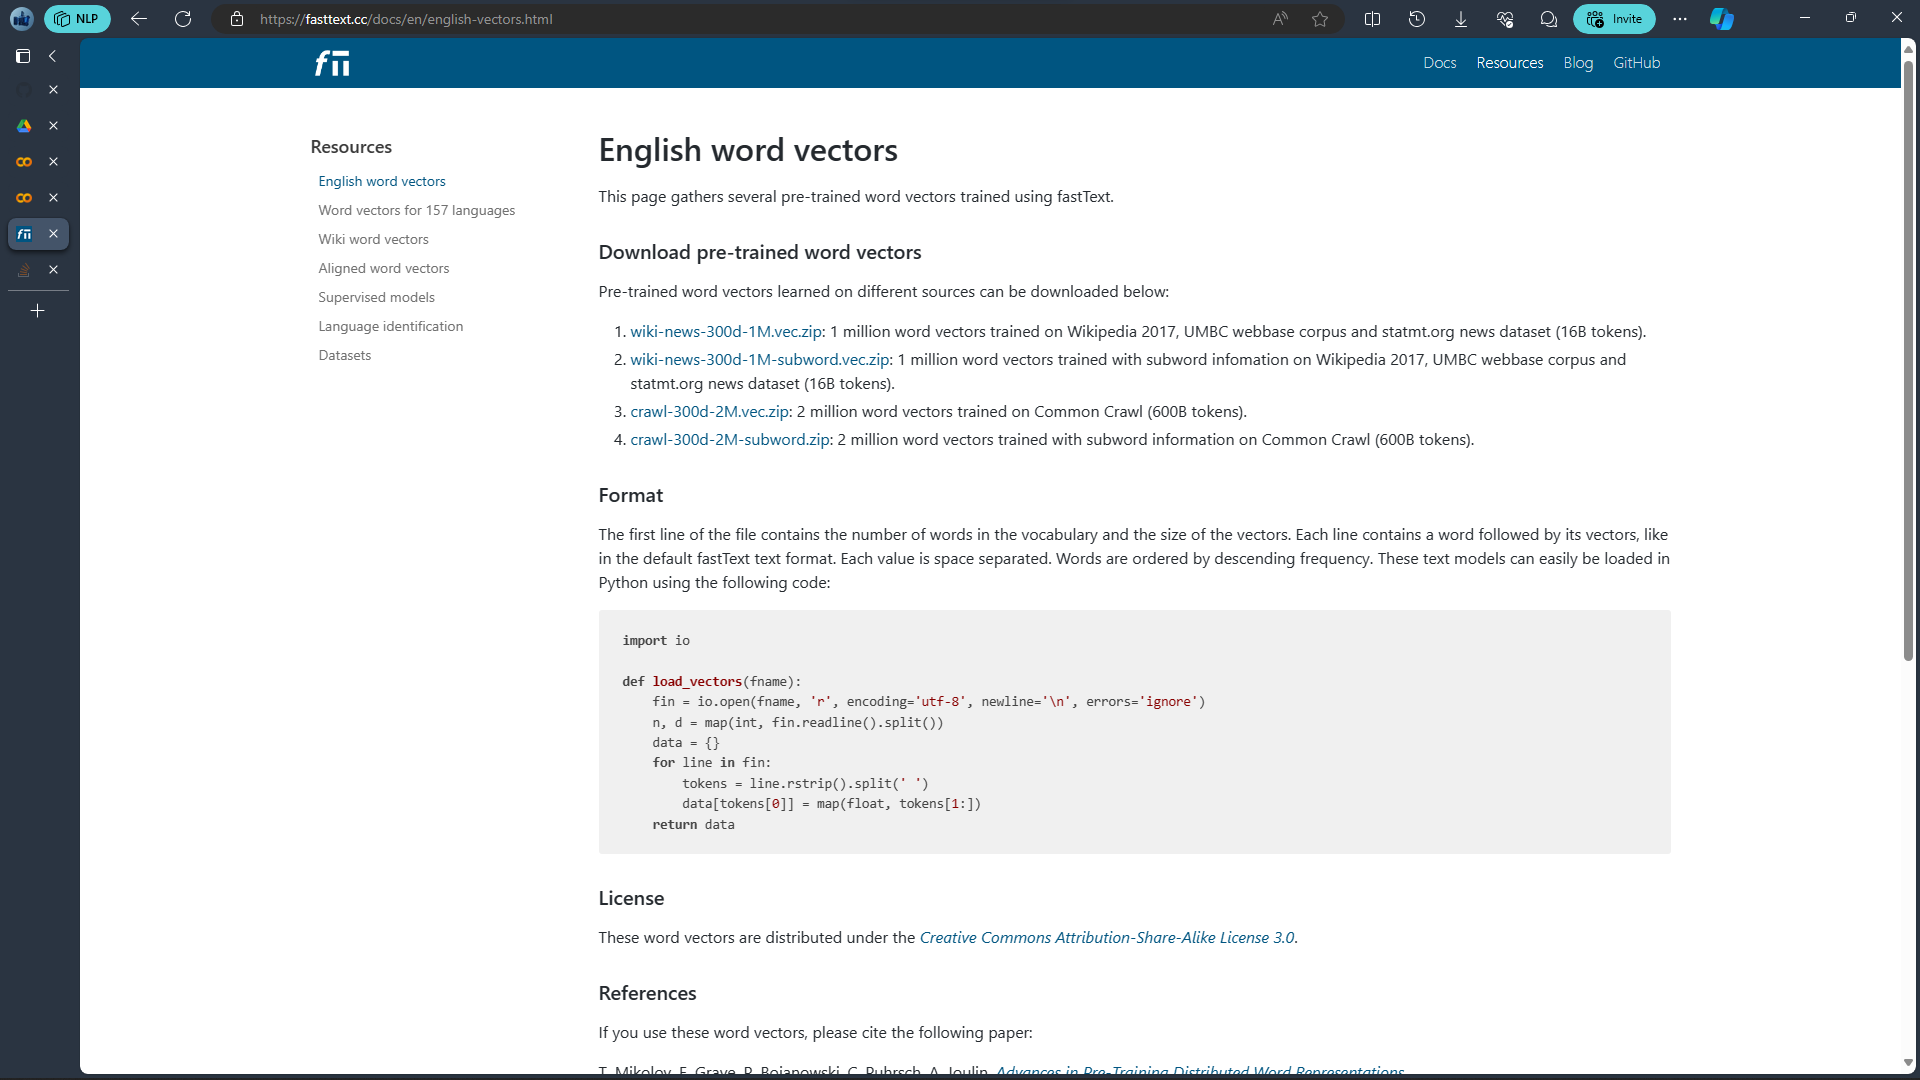

In [15]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

Đoạn này để download bộ w2v về, đã download r, k cần chạy

In [16]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

    os.remove('wiki-news-300d-1M.vec.zip')



---



In [17]:
fname = 'embeddings/wiki-news-300d-1M.vec'

embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12088, 300)

In [18]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 645


## 3. Create LSTM Pipeline

### Embedding Layer

Sử dụng pretrained w2v.

- vocabulary sizes: là số lượng tối đa các thuật ngữ được sử dụng để biểu diễn một văn bản. Ví dụ, nếu chúng ta đặt kích thước "từ vựng" là 1000, chỉ 1000 thuật ngữ xuất hiện nhiều nhất trong tập dữ liệu sẽ được xem xét (các thuật ngữ khác sẽ bị bỏ qua).

- maximum length (độ dài tối đa): tất cả văn bản phải có cùng độ dài.

- size của embedding: cơ bản, càng nhiều chiều thì ngữ nghĩa càng chính xác, nhưng vượt qua một ngưỡng nhất định, khả năng của nhúng để định nghĩa một khu vực ngữ nghĩa thống nhất và đủ tổng quát sẽ giảm.

- trainable:True nếu muốn fine-tune



In [19]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=True)

### Model Pipeline
- Input là N từ đầu tiên của mỗi sequence (proper padding)
- Tạo word embedding, dùng vocabulary (size và chiều đã cho trước)
- Tầng LSTM/GRU sẽ nhận word embedding cho mỗi token trong text input. Các token output sẽ lưu thông tin bao gồm token ban đầu và bất kỳ token nào trước đó (Hiểu là LSTM tạo ra một lớp encoding mới cho input ban đầu)
- Tầng output sử dụng hàm softmax làm activate function

Dùng GRU hay LSTM đều cho ra kết quả khá giống nhau, nhưng mà LSTM lâu hơn (nếu có thgian thì đổi GRU qua LSTM chạy thử)

In [20]:
gru_output_size = 128
lstm_output_size = 128

bidirectional = True

model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(LSTM(units=lstm_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(LSTM(units=gru_output_size,
                dropout=0.2,
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626400   
                                                                 
 bidirectional (Bidirection  (None, 256)               439296    
 al)                                                             
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 4066981 (15.51 MB)
Trainable params: 4066981 (15.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 3. Train the Model

In [ ]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/15
62/62 [==============================] - 229s 4s/step - loss: 1.3369 - accuracy: 0.4410 - val_loss: 1.0813 - val_accuracy: 0.5900
Epoch 2/15
62/62 [==============================] - 217s 3s/step - loss: 0.8157 - accuracy: 0.7135 - val_loss: 0.7889 - val_accuracy: 0.7097
Epoch 3/15
62/62 [==============================] - 213s 3s/step - loss: 0.5009 - accuracy: 0.8296 - val_loss: 0.7408 - val_accuracy: 0.7398
Epoch 4/15
62/62 [==============================] - 212s 3s/step - loss: 0.3545 - accuracy: 0.8819 - val_loss: 0.7809 - val_accuracy: 0.7377
Epoch 5/15
62/62 [==============================] - 212s 3s/step - loss: 0.2527 - accuracy: 0.9208 - val_loss: 0.8473 - val_accuracy: 0.7345
Epoch 6/15
62/62 [==============================] - 211s 3s/step - loss: 0.2054 - accuracy: 0.9376 - val_loss: 0.8983 - val_accuracy: 0.7365
Epoch 7/15
62/62 [==============================] - 208s 3s/step - loss: 0.1639 - accuracy: 0.9517 - val_loss: 1.0777 - val_accuracy: 0.7286
Epoch 8/15
62

In [ ]:
hist.history

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. Evaluation

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

#### Plotting confusion Matrix:

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## Lưu model

In [ ]:
model.save('models/LSTM_w2v.h5')

## Thử với một message khác

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

In [ ]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))